## Lake Zug APhys-AChem Meeting (15.12.2025)

Summary analyses of data from last winter.

In [3]:
# imports
import os
from glob import glob
import json
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import dolfyn as dlfn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ewgreaders as ewg
import pylake

In [2]:
lake = 'Zugersee'
location = 'LZ2'
year = '2025'
date = '20250108'

In [3]:
mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
mxsc, mysc = mreader.get_swiss_coords()
bathy_file = mreader.BATHY_PATH.format(lake=lake)
bathy = xr.open_dataset(bathy_file)
coronal = bathy.sel(ysc=mysc)
adcps = mreader.get_adcps()
thermistors = mreader.get_thermistors()
oxygen_loggers = mreader.get_oxygen_loggers()

### CTD Data

Select profiles during the mooring deployment and within 100 m radius of mooring.  Calculate thermocline depth, epilimnion and hypolimnion regions, and anoxic depth.

pylake functions struggle with some of the data, as does my anoxic region calculation.

In [4]:
# deployment and retrieval dates
dt_deploy = datetime.strptime(mreader.md['deployment'], "%d.%m.%Y")
dt_retrieve = datetime.strptime(mreader.md['retrieval'], "%d.%m.%Y")

ctd_dirs = []
for yr in ['2024', '2025']:
    ctd_root = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{yr}/CTD'
    for d in os.listdir(ctd_root):
        dt_ctd = datetime.strptime(d, "%Y%m%d")

        if dt_deploy <= dt_ctd <= dt_retrieve:
            ctd_dirs.append(os.path.join(ctd_root, d))

ctd_dirs

['Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241108',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241114',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241126',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241204',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241205']

In [5]:
ctd_data = []
for d in ctd_dirs:
    dpath_L1 = os.path.join(d, "L1")
    for f in os.listdir(dpath_L1):
        fpath_L1 = os.path.join(dpath_L1, f)
        ds = xr.open_dataset(fpath_L1)
        day = datetime.strptime(ds.attrs['Date of measurement'], "%Y-%m-%d")
        xsc = int(ds.attrs['X Coordinate (CH1903)']) + int(2e6)
        ysc = int(ds.attrs['Y Coordinate (CH1903)']) + int(1e6)
        mdist = np.sqrt((xsc - mxsc)**2 + (ysc - mysc)**2)

        # profile within 100 m of mooring
        if mdist < 100:
            # only keep samples with valid depths, quality checked temperature
            mask = ds['depth'].notnull() & (ds['Temp_qual'] == 0)
            depth = ds['depth'][mask]
            temp = ds['Temp'][mask]
            try:
                mld = pylake.mixed_layer(temp.values, depth.values)
                thermocline_depth, _ = pylake.seasonal_thermocline(temp.values, depth.values)
                epi_depth, hypo_depth = pylake.metalimnion(temp.values, depth.values, seasonal=True)
                anoxic_depth, anoxic_dox, anoxic_sem = ewg.datsci.lakes.locate_anoxia(ds)
            except Exception:
                continue

            ctd_data.append({
                'date': day,
                'month': day.month,
                'xsc': xsc,
                'ysc': ysc,
                'mld': mld,
                'thermocline_depth': thermocline_depth,
                'epilimnion_depth': epi_depth,
                'hypolimnion_depth': hypo_depth,
                'anoxic_depth': anoxic_depth,
                'profile_depth': ds['depth'].max().item(),
                'total_depth': bathy.sel(xsc=xsc, ysc=ysc).depth.item()
            })

ctd_data = pd.DataFrame(ctd_data)
ctd_data['date'] = ctd_data['date'].dt.date

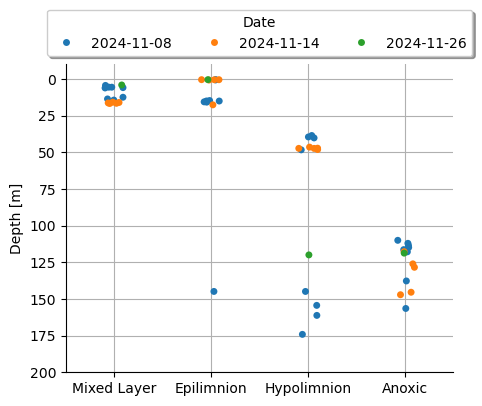

In [7]:
dfm = pd.melt(ctd_data, id_vars=['date'], value_vars=['mld', 'epilimnion_depth', 'thermocline_depth', 'anoxic_depth'],
              var_name='region', value_name='depth')

fig, ax = plt.subplots(figsize=(5, 4))
reg_order = ['mld', 'epilimnion_depth', 'thermocline_depth', 'anoxic_depth']

sns.stripplot(dfm, x='region', y='depth', order=reg_order, hue='date', ax=ax)

ax.set_xticks(np.arange(len(reg_order)), labels=['Mixed Layer', 'Epilimnion', 'Hypolimnion', 'Anoxic'])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')

ax.set_ylim(-10, 200)
ax.invert_yaxis()
ax.grid(True)
ax.spines[['right', 'top']].set_visible(False)

ax.legend(title='Date', ncols=3, shadow=True, loc='upper center', bbox_to_anchor=(0.5, 1.2))

### ADCP Data

Calculate flux in anoxic layer.

In [8]:
def calculate_flux(ds, depth, coronal):
    v = ds.vel.sel(dir='N')
    bin_size = ds.attrs['cell_size']
    mask = (coronal.depth > depth - bin_size/2) & (coronal.depth < depth + bin_size/2)
    idxs = np.where(mask)[0]

    # only one jump = found borders
    if np.count_nonzero(np.diff(idxs) - 1) <= 1:
        idx_w = idxs[0]
        idx_e = idxs[-1]

    # multiple jumps, search from E
    else:
        idx_e = idxs[-1]
        jump_idx = []
        for i, idx in enumerate(idxs[:-1]):
            if idxs[i+1] - idx != 1:
                jump_idx.append(idxs[i+1])

        idx_w = jump_idx[-2]

    # width of constriction at this depth
    xw = coronal.xsc[idx_w].item()
    xe = coronal.xsc[idx_e].item()
    width = xe - xw

    # area of rectangle [m^2]
    da = width * bin_size

    # flux = velocity * cross-section area
    flux = (v.sel(range=depth, method='nearest') * da).rename('flux')

    return flux.to_dataset()

In [9]:
adcps

[{'instrument': 'adcp',
  'serial_id': '8315',
  'mab': 0,
  'comments': 'up, (680083, 218850)'},
 {'instrument': 'adcp', 'serial_id': '16549', 'mab': 15.75, 'comments': 'up'},
 {'instrument': 'adcp', 'serial_id': '16576', 'mab': 125, 'comments': 'down'},
 {'instrument': 'adcp', 'serial_id': '24399', 'mab': 125, 'comments': 'up'}]

In [ ]:
# ADCP at oxic-anoxic interface
serial_id = '16549'

areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
fpath = areader.locate_data_file('L0')
ds = areader.load_from_L0(fpath)
ds = areader.range_to_depth(ds)
ds = areader.run_qa(ds)


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\3U16549.000 ...


In [11]:
flux_data = []
for d in ds.range.values:
    flux = calculate_flux(ds, d, coronal)
    flux_data.append(flux)

flux_data = xr.concat(flux_data, dim='range')

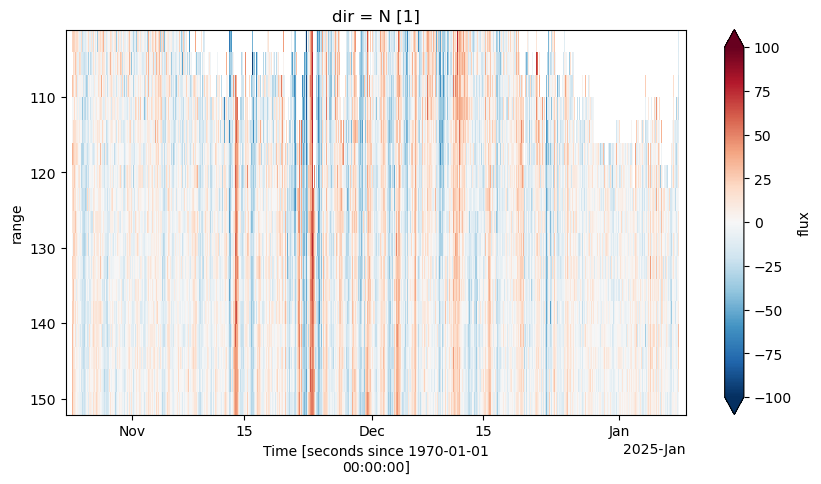

In [12]:
# require 50% data validity
thresh = 0.5
valid_depths = flux_data['flux'].notnull().mean(dim='time')

flux_data = flux_data.sel(range=valid_depths >= thresh)

fig, ax = plt.subplots(figsize=(10, 5))
flux_data.flux.plot(cmap='RdBu_r', vmin=-100, vmax=100, ax=ax)

ax.invert_yaxis()
plt.show()

In [41]:
dt = 600    # 10 minutes (try to calculate this, not hard code)
net_flux = flux_data['flux'].sum(dim='time') * dt

nf = flux_data['flux'].where(flux_data['flux'].notnull()).integrate(coord='time')

In [58]:
time_s = (flux_data.time - flux_data.time[0]).astype('timedelta64[s]').astype(float)

transport = flux_data['flux'].assign_coords(time=time_s).fillna(0).integrate('time')
transport

<xarray.DataArray 'flux' (range: 17)> Size: 136B
array([  4261355.9653759 ,   3252589.2432332 ,   4342788.02608252,
        -1212143.42494011,   -391564.79902267,  -2078028.10964584,
        -2475430.26309013,  -3002472.02231884,  -4694468.43001842,
        -6173100.01266003,  -8590320.01669407,  -8587566.02554321,
        -9263491.27135277, -10310849.94521141, -11386035.0646019 ,
       -10340999.98794794,  -3355488.0443573 ])
Coordinates:
    dir      <U3 12B 'N'
  * range    (range) float64 136B 150.6 147.6 144.6 141.6 ... 108.6 105.6 102.6

In [53]:
flux = flux_data['flux'].where(flux_data['flux'].notnull())
transport = flux_data['flux'].fillna(0).integrate('time')
transport

<xarray.DataArray 'flux' (range: 17)> Size: 136B
array([ 4.26135597e+15,  3.25258924e+15,  4.34278803e+15, -1.21214342e+15,
       -3.91564799e+14, -2.07802811e+15, -2.47543026e+15, -3.00247202e+15,
       -4.69446843e+15, -6.17310001e+15, -8.59032002e+15, -8.58756603e+15,
       -9.26349127e+15, -1.03108499e+16, -1.13860351e+16, -1.03410000e+16,
       -3.35548804e+15])
Coordinates:
    dir      <U3 12B 'N'
  * range    (range) float64 136B 150.6 147.6 144.6 141.6 ... 108.6 105.6 102.6

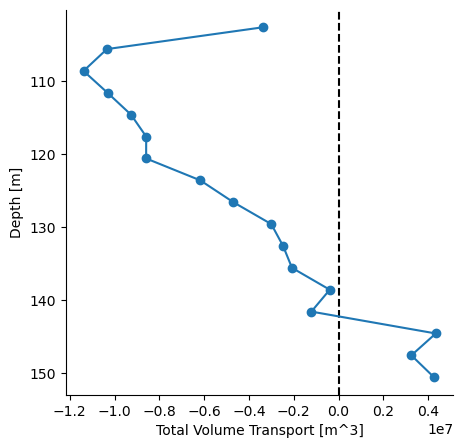

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
ax.plot(transport.values, transport.range, marker='o')

ax.set_xlabel('Total Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

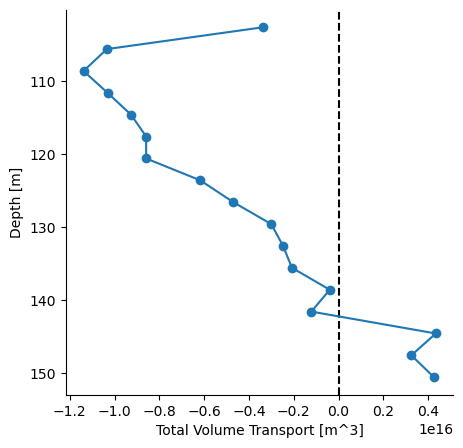

In [55]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
ax.plot(transport.values, transport.range, marker='o')

ax.set_xlabel('Total Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

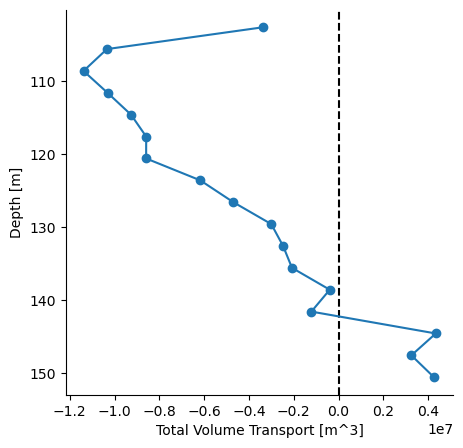

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
ax.plot(net_flux.values, net_flux.range, marker='o')

ax.set_xlabel('Total Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [15]:
# daily average
df = flux_data.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

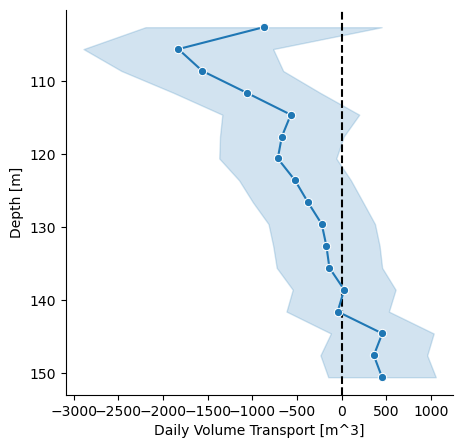

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
sns.lineplot(df_avg, x='flux', y='range', orient='y', marker='o', errorbar=('se', 1), err_style='band', ax=ax)

ax.set_xlabel('Daily Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)
plt.show()

### End of presentation

In [211]:
# ADCP at bottom
serial_id = '8315'

areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
fpath = areader.locate_data_file('L0')
ds = areader.load_from_L0(fpath)
ds = areader.range_to_depth(ds)
ds = areader.run_qa(ds)


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\12U8315.000 ...


In [212]:
flux_data = []
for d in ds.range.values:
    flux = calculate_flux(ds, d, coronal)
    flux_data.append(flux)

flux_data = xr.concat(flux_data, dim='range')

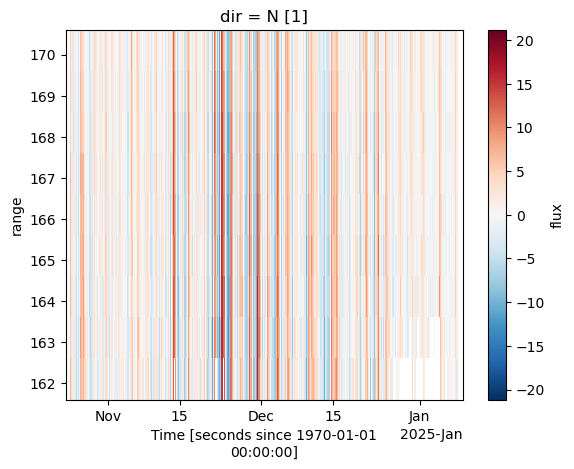

In [ ]:
thresh = 0.75
valid_depths = flux_data['flux'].notnull().mean(dim='time')

flux_data = flux_data.sel(range=valid_depths >= thresh)

flux_data.flux.plot()

In [214]:
dt = 600    # 10 minutes (try to calculate this, not hard code)
net_flux = flux_data['flux'].sum(dim='time') * dt

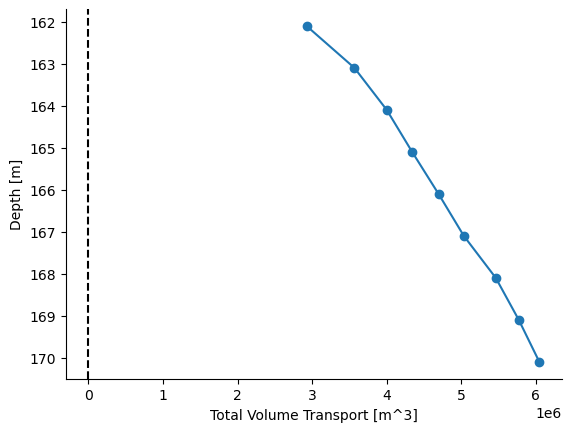

In [215]:
fig, ax = plt.subplots()

ax.axvline(0, color='black', linestyle='--')
ax.plot(net_flux.values, net_flux.range, marker='o')

ax.set_xlabel('Total Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [217]:
# ADCP at surface
serial_id = '24399'

areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
fpath = areader.locate_data_file('L0')
ds = areader.load_from_L0(fpath)
ds = areader.range_to_depth(ds)
ds = areader.run_qa(ds)


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\6U24399.000 ...


In [218]:
flux_data = []
for d in ds.range.values:
    flux = calculate_flux(ds, d, coronal)
    flux_data.append(flux)

flux_data = xr.concat(flux_data, dim='range')

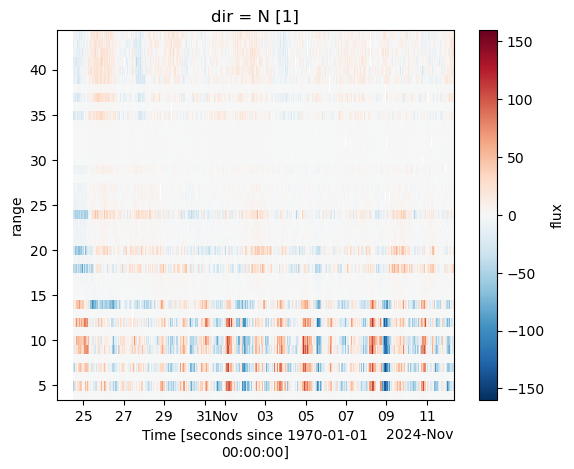

In [219]:
thresh = 0.75
valid_depths = flux_data['flux'].notnull().mean(dim='time')

flux_data = flux_data.sel(range=valid_depths >= thresh)

flux_data.flux.plot()

In [220]:
dt = 600    # 10 minutes (try to calculate this, not hard code)
net_flux = flux_data['flux'].sum(dim='time') * dt

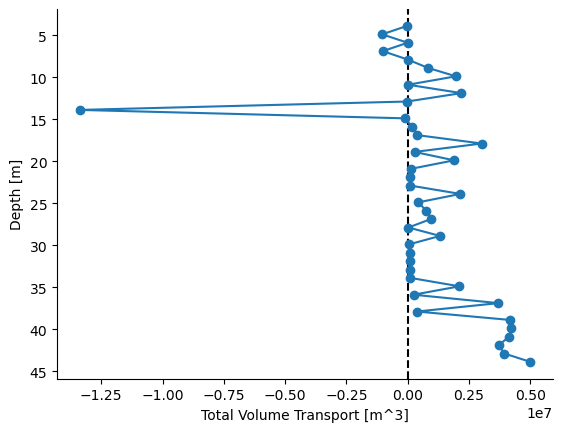

In [221]:
fig, ax = plt.subplots()

ax.axvline(0, color='black', linestyle='--')
ax.plot(net_flux.values, net_flux.range, marker='o')

ax.set_xlabel('Total Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

### Workspace

In [2]:
def plot_vel_kde(ds, thresh=0.9):
    vel_df = ds.vel.to_dataframe().reset_index().query("dir in ['N', 'E']")

    # only keep depths with threshold of valid data
    valid = vel_df.groupby('range')['vel'].agg(['count', 'size']).reset_index()
    valid['ratio'] = valid['count'] / valid['size']
    valid_depths = valid.query('ratio > @thresh')['range'].unique()
    vel_df = vel_df[vel_df['range'].isin(valid_depths)].dropna()

    palette = ['steelblue', 'palevioletred']
    dir_order = ['N', 'E']

    g = sns.displot(vel_df, x='vel', row='range', hue='dir', hue_order=dir_order, palette=palette,
                    kind='kde', fill=True, height=1, aspect=4)

    for ax in g.axes.flatten():
        ax.axvline(0, color='black', linestyle=':')

    g.set_titles("{row_name} m")
    g.set_xlabels('Velocity [m/s]')

    g._legend.set_title("Current Direction")
    g._legend.set_loc('upper right')
    g._legend.set_bbox_to_anchor((0.9, 1))


    plt.xlim(-0.05, 0.05)
    plt.show()


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\12U8315.000 ...


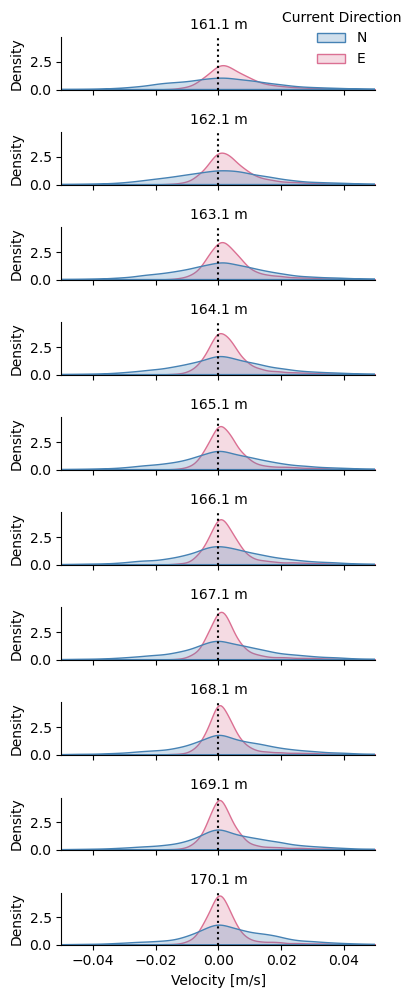


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\3U16549.000 ...


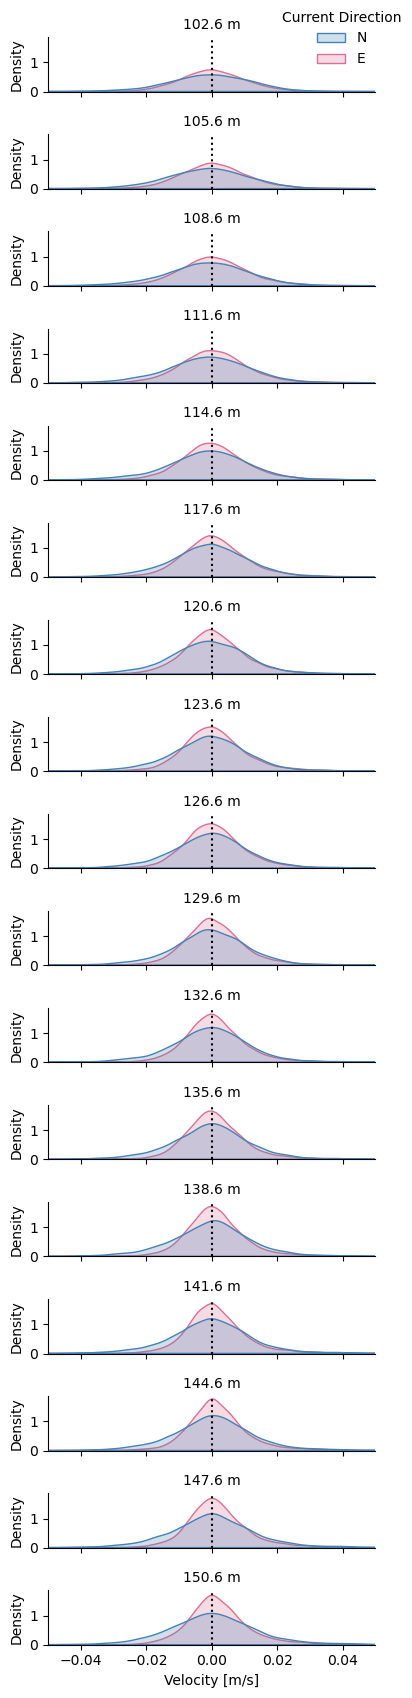


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\6D16576.000 ...


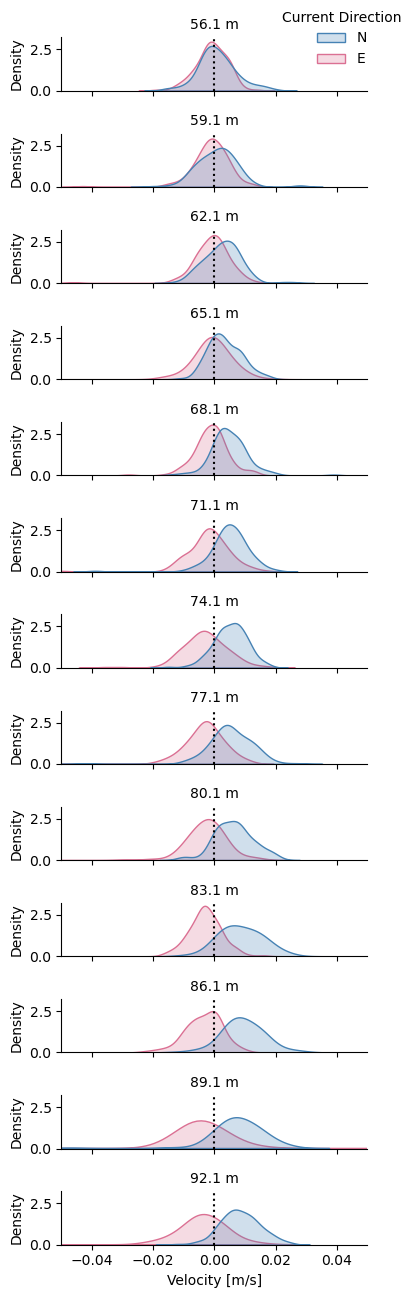


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\6U24399.000 ...


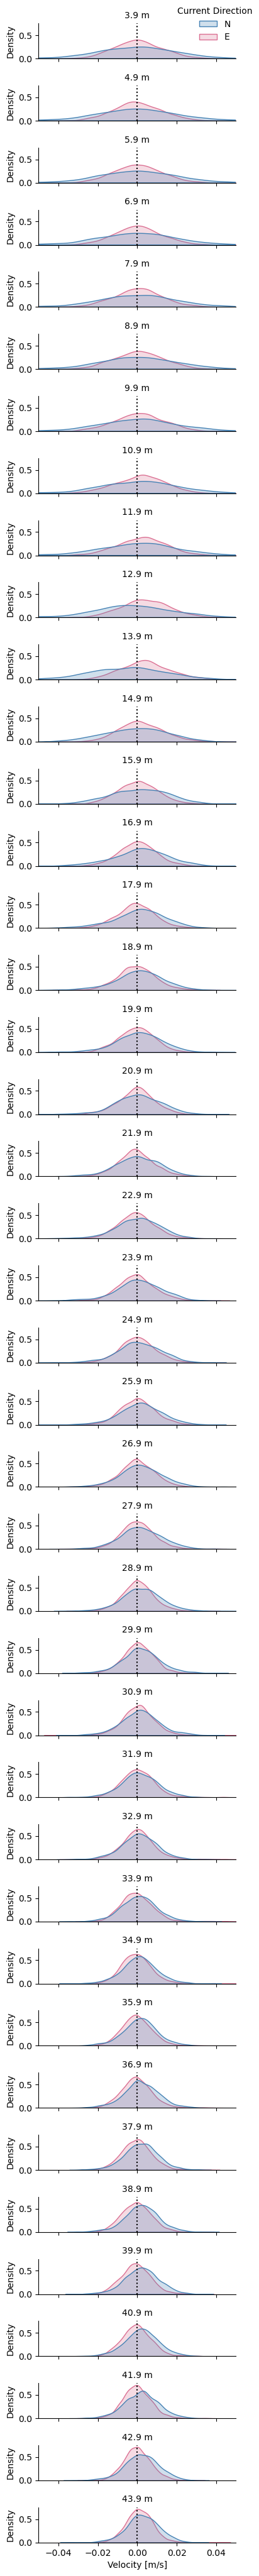

In [9]:
for adcp in adcps:
    areader = ewg.adcp_reader.ADCPReader(adcp['serial_id'], lake, location, year, date)
    fpath = areader.locate_data_file('L0')
    ds = areader.load_from_L0(fpath)
    ds = areader.range_to_depth(ds)
    ds = areader.run_qa(ds)
    plot_vel_kde(ds, thresh=0.5)

In [6]:
all_flux_data = []
for adcp in adcps:
    areader = ewg.adcp_reader.ADCPReader(adcp['serial_id'], lake, location, year, date)
    fpath = areader.locate_data_file('L0')
    ds = areader.load_from_L0(fpath)
    ds = areader.range_to_depth(ds)
    ds = areader.run_qa(ds)

    flux_data = []
    for d in ds.range.values:
        flux = calculate_flux(ds, d, coronal)
        flux_data.append(flux)

    flux_data = xr.concat(flux_data, dim='range')
    all_flux_data.append(flux_data)
#aligned = xr.align(*flux_data, join='outer')
#dsf = xr.concat(aligned, dim='range')


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\12U8315.000 ...

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\3U16549.000 ...

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\6D16576.000 ...

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/Mooring/20250108/LZ2/L0\6U24399.000 ...


In [7]:
depth_order = np.sort(ds['range'])
depth_order

array([ 2.9,  3.9,  4.9,  5.9,  6.9,  7.9,  8.9,  9.9, 10.9, 11.9, 12.9,
       13.9, 14.9, 15.9, 16.9, 17.9, 18.9, 19.9, 20.9, 21.9, 22.9, 23.9,
       24.9, 25.9, 26.9, 27.9, 28.9, 29.9, 30.9, 31.9, 32.9, 33.9, 34.9,
       35.9, 36.9, 37.9, 38.9, 39.9, 40.9, 41.9, 42.9, 43.9])

In [32]:
vel_df = ds.vel.to_dataframe().reset_index().query("dir in ['N', 'E']")
vel_df

,dir,range,time,vel
0,E,43.9,2024-10-23 16:39:25.032320022,NaN
1,E,43.9,2024-10-23 16:49:25.032320022,NaN
2,E,43.9,2024-10-23 16:59:25.032320022,NaN
3,E,43.9,2024-10-23 17:09:25.032320022,NaN
4,E,43.9,2024-10-23 17:19:25.032320022,NaN
...,...,...,...,...
237631,N,2.9,2024-11-12 07:19:25.032320022,NaN
237632,N,2.9,2024-11-12 07:29:25.032320022,NaN
237633,N,2.9,2024-11-12 07:39:25.032320022,NaN
237634,N,2.9,2024-11-12 07:49:25.032320022,-0.239


In [33]:
valid = vel_df.groupby('range')['vel'].agg(['count', 'size']).reset_index()
valid['ratio'] = valid['count'] / valid['size']
valid_depths = valid.query('ratio > 0.9')['range'].unique()

In [34]:
vel_df = vel_df[vel_df['range'].isin(valid_depths)].dropna()
vel_df

,dir,range,time,vel
113,E,43.9,2024-10-24 11:29:25.032320022,0.043
114,E,43.9,2024-10-24 11:39:25.032320022,0.021
115,E,43.9,2024-10-24 11:49:25.032320022,0.015
116,E,43.9,2024-10-24 11:59:25.032320022,0.009
117,E,43.9,2024-10-24 12:09:25.032320022,0.007
...,...,...,...,...
234802,N,3.9,2024-11-12 07:19:25.032320022,0.001
234803,N,3.9,2024-11-12 07:29:25.032320022,0.004
234804,N,3.9,2024-11-12 07:39:25.032320022,-0.010
234805,N,3.9,2024-11-12 07:49:25.032320022,-0.015


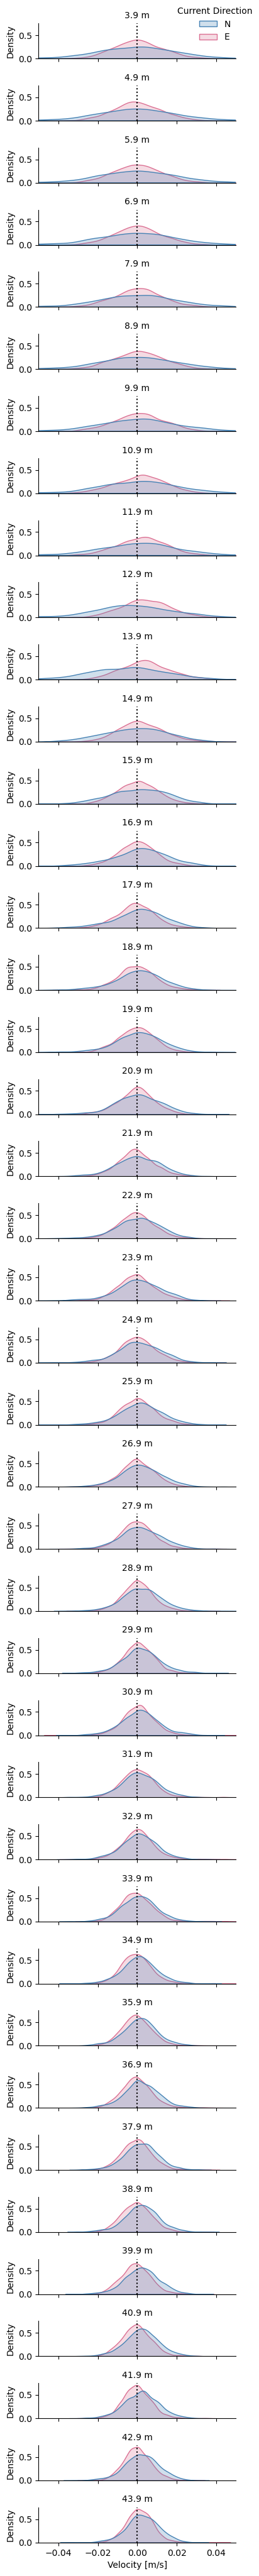

In [36]:
palette = ['steelblue', 'palevioletred']
dir_order = ['N', 'E']

g = sns.displot(vel_df, x='vel', row='range', hue='dir', hue_order=dir_order, palette=palette,
                kind='kde', fill=True, height=1, aspect=4)

for ax in g.axes.flatten():
    ax.axvline(0, color='black', linestyle=':')

g.set_titles("{row_name} m")
g.set_xlabels('Velocity [m/s]')

g._legend.set_title("Current Direction")
g._legend.set_loc('upper right')
g._legend.set_bbox_to_anchor((0.9, 1))


plt.xlim(-0.05, 0.05)
plt.show()

In [6]:
len(all_flux_data)

4

2024-10-23T16:55:02.017855882 2025-01-09T09:45:02.017855882
2024-10-23T16:16:53.017855882 2025-01-09T09:26:53.017855882
2024-10-23T16:43:50.033567905 2024-10-25T11:33:50.033567905
2024-10-23T16:39:25.032320022 2024-11-12T07:59:25.032320022


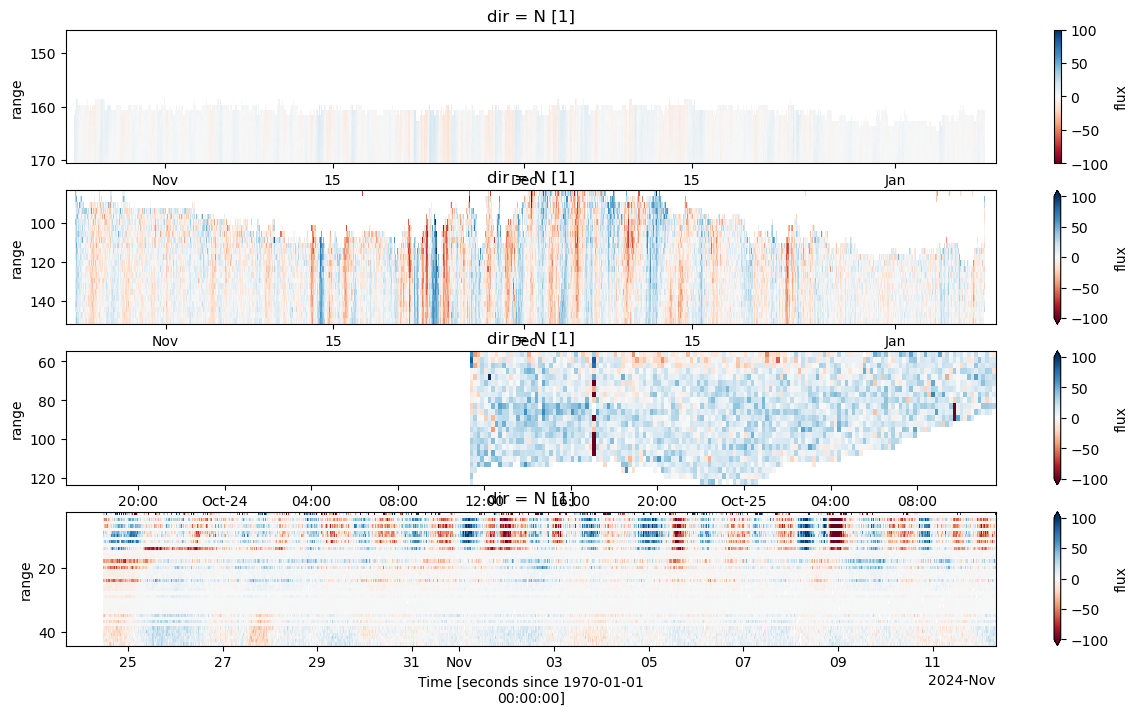

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 8), sharex=False)

for i, fd in enumerate(all_flux_data):
    print(fd.time.values[0], fd.time.values[-1])
    fd.flux.plot(ax=ax[i], vmin=-100, vmax=100, cmap='RdBu')
    ax[i].invert_yaxis()

plt.show()

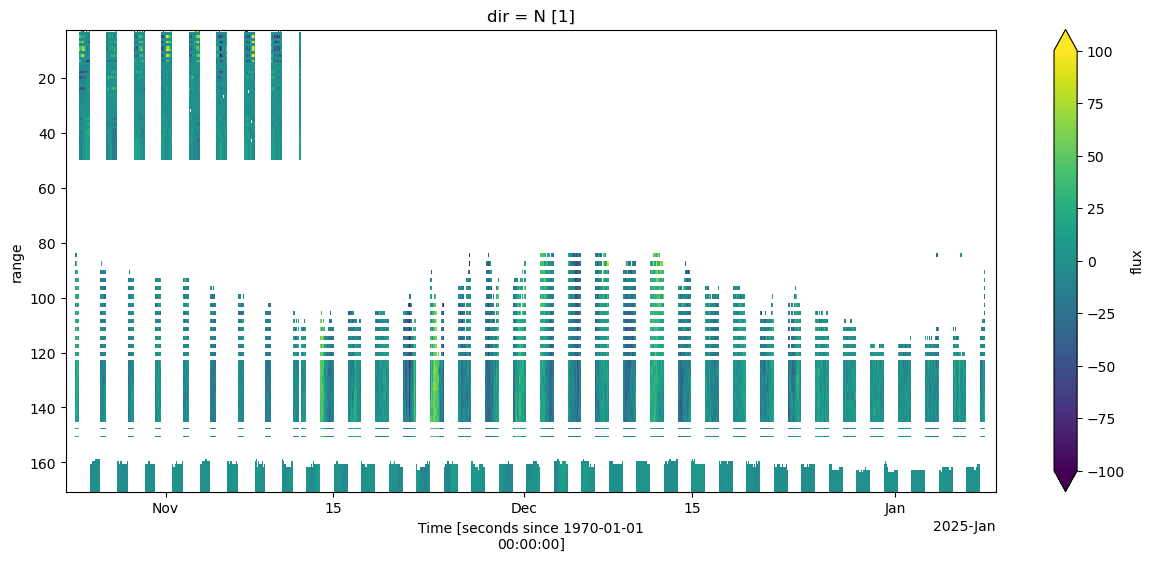

In [317]:
fig, ax = plt.subplots(figsize=(15, 6))

dsf.flux.plot(ax=ax, vmin=-100, vmax=100)

ax.invert_yaxis()

plt.show()

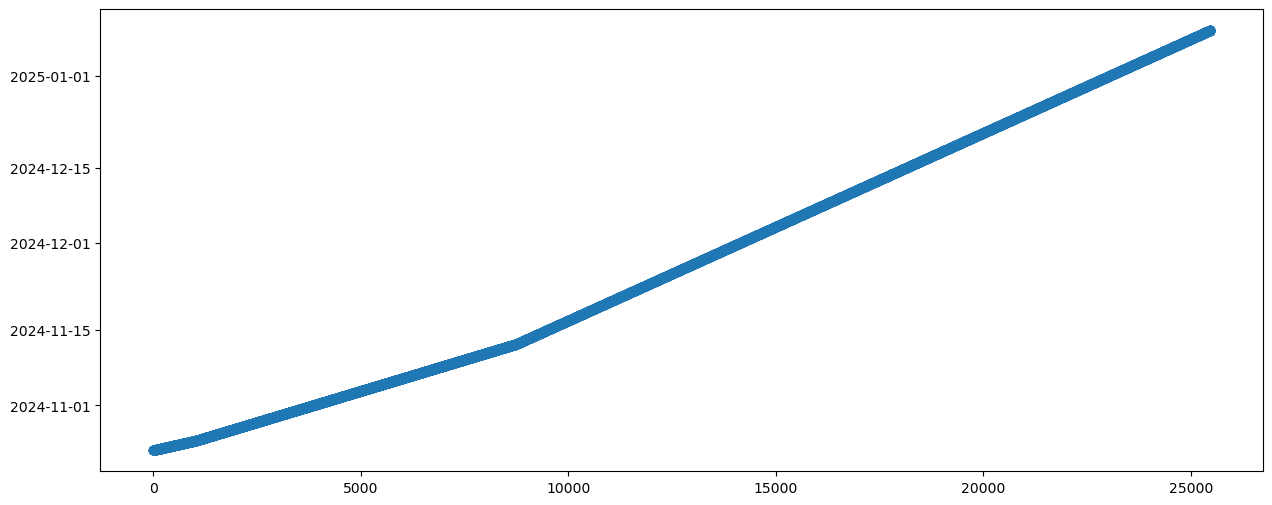

In [267]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(dsf.time, marker='o')

In [242]:
aligned = xr.align(*[flux_data[0], flux_data[-1]], join='outer')

In [244]:
dat = xr.concat(aligned, dim='range')
dat

<xarray.DataArray 'flux' (range: 2, time: 14019)> Size: 112kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(2, 14019), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 112kB 2024-10-23T16:39:25.032320022 ... 20...
    dir      <U3 12B 'N'
  * range    (range) float64 16B 170.1 2.889

### CTD Data

Select profiles from same date range of mooring deployment.

In [41]:
dt_deploy = datetime.strptime(mreader.md['deployment'], "%d.%m.%Y")
dt_retrieve = datetime.strptime(mreader.md['retrieval'], "%d.%m.%Y")

mxsc, mysc = mreader.get_swiss_coords()

In [42]:
ctd_dirs = []
for yr in ['2024', '2025']:
    ctd_root = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{yr}/CTD'
    for d in os.listdir(ctd_root):
        dt_ctd = datetime.strptime(d, "%Y%m%d")

        if dt_deploy <= dt_ctd <= dt_retrieve:
            ctd_dirs.append(os.path.join(ctd_root, d))

ctd_dirs

['Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241108',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241114',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241126',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241204',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241205']

np.float64(180.33579788827288)

In [48]:
ctd_data = []
for d in ctd_dirs:
    dpath_L1 = os.path.join(d, "L1")
    for f in os.listdir(dpath_L1):
        fpath_L1 = os.path.join(dpath_L1, f)
        ds = xr.open_dataset(fpath_L1)
        date = datetime.strptime(ds.attrs['Date of measurement'], "%Y-%m-%d")
        xsc = int(ds.attrs['X Coordinate (CH1903)']) + int(2e6)
        ysc = int(ds.attrs['Y Coordinate (CH1903)']) + int(1e6)
        mdist = np.sqrt((xsc - mxsc)**2 + (ysc - mysc)**2)

        # profile within 100 m of mooring
        if mdist < 100:
            # only keep samples with valid depths, quality checked temperature
            mask = ds['depth'].notnull() & (ds['Temp_qual'] == 0)
            depth = ds['depth'][mask]
            temp = ds['Temp'][mask]
            try:
                thermocline_depth, _ = pylake.seasonal_thermocline(temp.values, depth.values)
                epi_depth, hypo_depth = pylake.metalimnion(temp.values, depth.values, seasonal=True)
                anoxic_depth, anoxic_dox, anoxic_sem = ewg.datsci.lakes.locate_anoxia(ds)
            except Exception:
                continue
            

            ctd_data.append({
                'date': date,
                'month': date.month,
                'xsc': xsc,
                'ysc': ysc,
                'thermocline_depth': thermocline_depth,
                'epilimnion_depth': epi_depth,
                'hypolimnion_depth': hypo_depth,
                'anoxic_depth': anoxic_depth,
                'profile_depth': ds['depth'].max().item(),
                'total_depth': bathy.sel(xsc=xsc, ysc=ysc).depth.item()
            })

ctd_data = pd.DataFrame(ctd_data)

In [49]:
ctd_data

,date,month,xsc,ysc,thermocline_depth,epilimnion_depth,hypolimnion_depth,anoxic_depth,profile_depth,total_depth
0,2024-11-08,11,2680090,1218816,161.213384,15.611666,161.213521,116.377829,161.231565,177.62001
1,2024-11-08,11,2680090,1218816,48.344007,0.584791,48.344007,117.872722,162.549198,177.62001
2,2024-11-08,11,2680090,1218816,174.149681,15.055864,174.315454,112.083520,174.319259,177.62001
3,2024-11-08,11,2680090,1218816,40.214498,15.821177,40.214498,114.886176,171.436239,177.62001
4,2024-11-08,11,2680090,1218816,39.543530,14.717640,39.543530,156.490976,165.954895,177.62001
5,2024-11-08,11,2680090,1218816,38.569578,0.576865,163.648444,137.734600,163.684429,177.62001
6,2024-11-08,11,2680090,1218816,154.384027,15.025613,154.384027,113.545943,154.373344,177.62001
7,2024-11-08,11,2680090,1218816,144.892531,144.881825,144.892531,110.031582,145.777560,177.62001
8,2024-11-14,11,2680090,1218816,47.325863,17.642204,47.325863,117.770766,163.519182,177.62001
9,2024-11-14,11,2680031,1218814,47.364423,0.550191,47.364423,145.428121,163.841649,177.88000


In [107]:
slope_f0 = (temp.min().item() - temp.max().item()) / (depth.max().item() - depth.min().item())
slope_lr, _, _, _, _ = scipy.stats.linregress(depth, temp)
slope = np.mean([slope_f0, slope_lr])
slope_f0, slope_lr, slope

(-0.03236275909707426,
 np.float64(-0.029476738119101988),
 np.float64(-0.030919748608088125))

In [30]:
anoxic_depth, anoxic_dox, anoxic_sem = ewg.datsci.lakes.locate_anoxia(ds)
anoxic_depth

np.float64(123.29143103657513)

In [20]:
# Savitzky-Golay filter
window_length = 10
polyorder = 3
mode = 'nearest'

temp_filt = scipy.signal.savgol_filter(temp, window_length, polyorder, mode=mode)

In [21]:
temp_ra = ewg.datsci.lakes.rolling_average(temp, depth, 1)

In [22]:
dTdz = np.gradient(temp, depth)
dTdz_filt = np.gradient(temp_filt, depth)
dTdz_ra = np.gradient(temp_ra, depth)

In [23]:
np.argmin(dTdz_ra)

np.int64(61)

In [24]:
depth[61]

<xarray.DataArray 'depth' ()> Size: 8B
array(0.430834)
Coordinates:
    time     datetime64[ns] 8B 2024-11-26T02:09:19
Attributes:
    units:      m
    long_name:  Depth

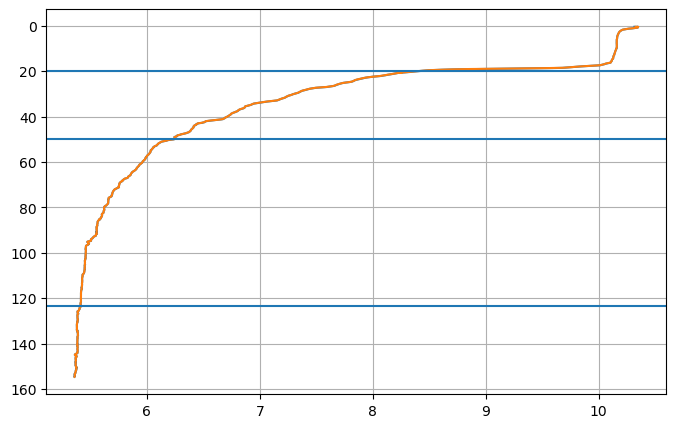

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(temp, depth)
ax.plot(temp_filt, depth)
ax.axhline(20)
ax.axhline(50)
ax.axhline(anoxic_depth)

ax.invert_yaxis()
ax.grid(True)

plt.show()

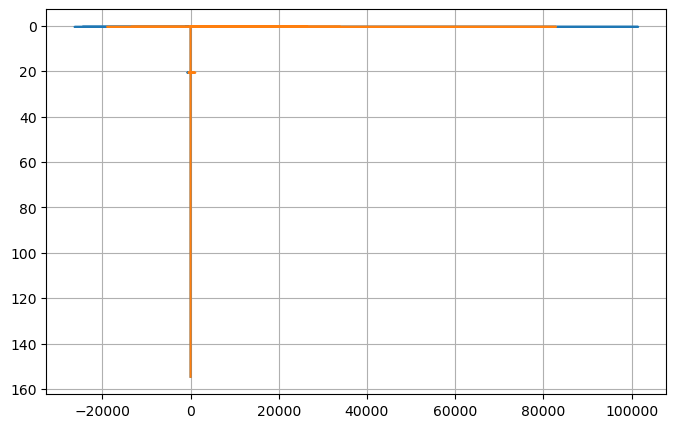

In [123]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(dTdz, depth)
ax.plot(dTdz_filt, depth)

ax.invert_yaxis()
ax.grid(True)

plt.show()

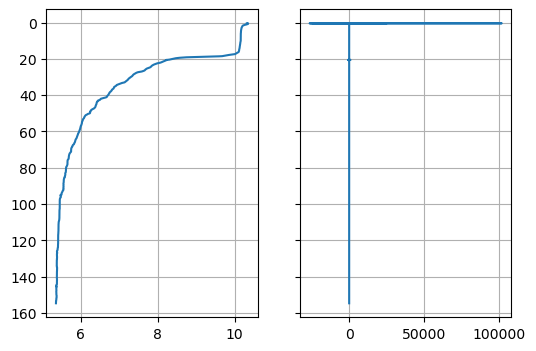

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), sharey=True)

ax[0].plot(temp, depth)
ax[1].plot(dTdz, depth)

ax[0].invert_yaxis()
ax[0].grid(True)
ax[1].grid(True)

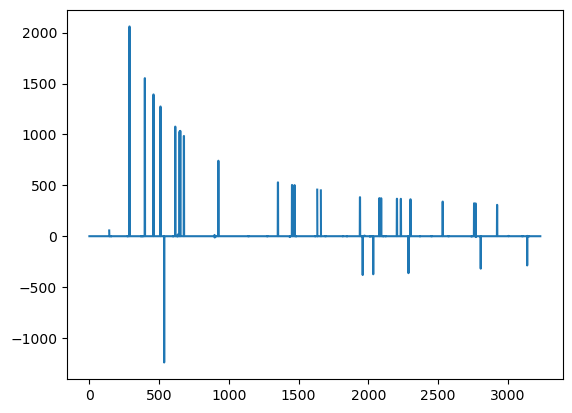

In [86]:
plt.plot(dTdz)

In [84]:
np.nanmedian(dTdz)

np.float64(-6.217248937900877e-15)

In [59]:
anoxic_data.dropna(subset=['anoxic_depth']).month.unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11,  1,  2])

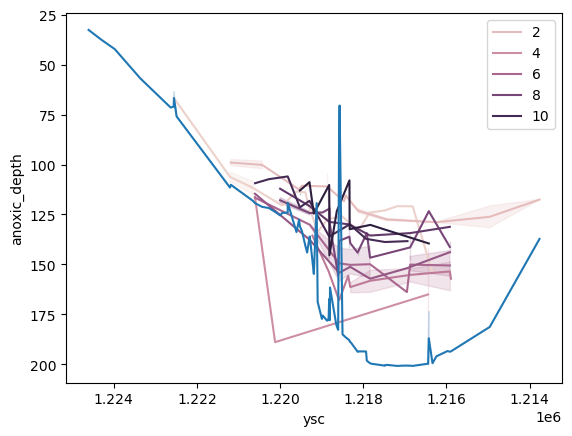

In [56]:
fig, ax = plt.subplots()

sns.lineplot(anoxic_data, x='ysc', y='anoxic_depth', hue='month',ax=ax)
sns.lineplot(anoxic_data, x='ysc', y='total_depth', ax=ax)

ax.invert_xaxis()
ax.invert_yaxis()

In [ ]:
bathy.sel(xsc=int(ds.attrs['X Coordinate (CH1903)']) + int(2e6), ysc=int(ds.attrs['Y Coordinate (CH1903)']) + int(1e6)).depth.item()

181.10001

In [14]:
ds.attrs['X Coordinate (CH1903)'], ds.attrs['Y Coordinate (CH1903)'], ds.attrs['Date of measurement']

('679980', '222561', '2024-11-26')

In [21]:
ds.attrs

{'institution': 'Eawag',
 'source': 'SURF CTD',
 'references': 'EAWAG SURF CTD profiles',
 'history': 'See history on Renku',
 'conventions': 'CF 1.7',
 'comment': 'Data from CTD profiles collected by the SURF Department at Eawag',
 'title': 'Surf CTD',
 'Campaign Name': '20241126_IBEX_Zug',
 'Project Name': 'IBEX',
 'Device': 'Sea&Sun CTD (1807)',
 'Serial No': '1807',
 'Person in charge': 'Jemima Rama',
 'Other people involved': 'David Janssen, Patrick Kathriner, Yana Kirichenko',
 'Date of measurement': '2024-11-26',
 'Time Zone device (UTC+)': '0',
 'Time Zone local (UTC+)': '1',
 'Lake': 'Lake Zug',
 'Coordinate System': 'CH1903 (Swiss Grid)',
 'Altitude (m)': '413',
 'General comment': 'Sunny, calm condition',
 'Profile name': 'p07',
 'Time of measurement (local)': '15:07',
 'X Coordinate (CH1903)': '680101',
 'Y Coordinate (CH1903)': '218636',
 'Start pressure (dbar)': '-0.2452',
 'End pressure (dbar)': '151.5094',
 'Something broke': 'False',
 'Something got lost': 'False',
 'S

In [9]:
# only keep samples with valid depths, quality checked dissolved oxygen
mask = ds['depth'].notnull() & (ds['DO_mg_qual'] == 0)
depth = ds['depth'][mask].values
dox_conc = ds['DO_mg'][mask].values

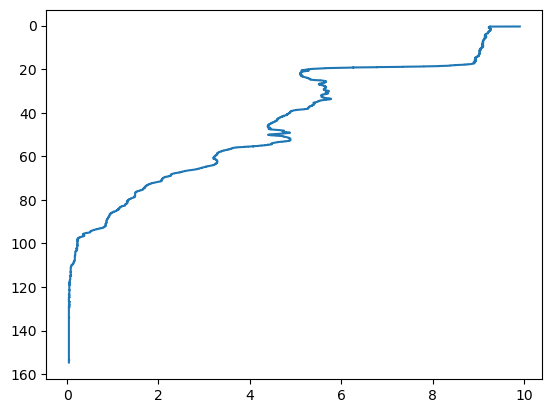

In [10]:
fig, ax = plt.subplots()

ax.plot(dox_conc, depth)

ax.invert_yaxis()

plt.show()

In [70]:
min_dox_conc = d_oxygen_conc.min().item()
min_dox_conc

0.04

In [74]:
idx = np.where(d_oxygen_conc == min_dox_conc)

In [76]:
depth[idx].min()

<xarray.DataArray 'depth' ()> Size: 8B
array(123.29143104)

In [82]:
args = [1, 2, 3]

def fxn(*args):
    for arg in args:
        print(arg)

fxn(*args)

1
2
3


In [92]:
np.where(d_oxygen_conc == d_oxygen_conc.max().item())[0][0]

np.int64(0)

In [85]:
np.argmin([1, 2, 3, 4, 1])

np.int64(0)

In [84]:
-np.inf

-inf

In [68]:
d_oxygen_conc.min().item()

0.04

In [66]:
depth.max().item()

154.64545541099272

In [ ]:
def calculate_anoxia(data, dp, err=0.2):
    min_o2_vals = []
    for i, dat in data.items():
        min_o2_vals.append(dat['d_oxygen_conc'].min())
    
    min_o2 = min(min_o2_vals)
    anoxia_data = []
    for i, dat in data.items():
        try:
            idx = np.where(dat['d_oxygen_conc'] <= min_o2 + err)[0][0]
            z = dat[dp][idx]
        except IndexError:
            z = np.nan

        anoxia_data.append({'idx': i, 'profile': dat['name'], 'anoxic_z': z, 'total_depth': dat['total_depth']})

    return pd.DataFrame(anoxia_data)

In [ ]:
def locate_anoxic_zone_start(ds):
    # only keep samples with valid depths, quality checked dissolved oxygen
    mask = ds['depth'].notnull() & (ds['DO_mg_qual'] == 0)

    depth = ds['depth'][mask].values
    dox = ds['DO_mg'][mask].values

    min_dox_idx = np.where(dox == min(dox))[0]
    anoxic_depth = min(depth[min_dox_idx])

    return anoxic_depth, min(dox)

In [53]:
ds.attrs

{'institution': 'Eawag',
 'source': 'SURF CTD',
 'references': 'EAWAG SURF CTD profiles',
 'history': 'See history on Renku',
 'conventions': 'CF 1.7',
 'comment': 'Data from CTD profiles collected by the SURF Department at Eawag',
 'title': 'Surf CTD',
 'Campaign Name': '20241126_IBEX_Zug',
 'Project Name': 'IBEX',
 'Device': 'Sea&Sun CTD (1807)',
 'Serial No': '1807',
 'Person in charge': 'Jemima Rama',
 'Other people involved': 'David Janssen, Patrick Kathriner, Yana Kirichenko',
 'Date of measurement': '2024-11-26',
 'Time Zone device (UTC+)': '0',
 'Time Zone local (UTC+)': '1',
 'Lake': 'Lake Zug',
 'Coordinate System': 'CH1903 (Swiss Grid)',
 'Altitude (m)': '413',
 'General comment': 'Sunny, calm condition',
 'Profile name': 'p07',
 'Time of measurement (local)': '15:07',
 'X Coordinate (CH1903)': '680101',
 'Y Coordinate (CH1903)': '218636',
 'Start pressure (dbar)': '-0.2452',
 'End pressure (dbar)': '151.5094',
 'Something broke': 'False',
 'Something got lost': 'False',
 'S

In [61]:
ds['thorpe'].values

array([nan, nan, nan, ..., nan, nan, nan], shape=(5856,))

In [47]:
ctd_dirs

['Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241108',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241114',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241126',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241204',
 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2024/CTD\\20241205']

In [38]:
dt_deploy

datetime.datetime(2024, 10, 24, 0, 0)

In [33]:
dt_deploy

datetime.datetime(2024, 10, 24, 0, 0)

In [97]:
d_oxygen_conc

<xarray.DataArray 'DO_mg' (time: 3846)> Size: 31kB
array([9.91, 9.76, 9.72, ..., 0.04, 0.04, 0.04], shape=(3846,))
Coordinates:
  * time     (time) datetime64[ns] 31kB 2024-11-26T02:09:10 ... 2024-11-26T02...
Attributes:
    units:      mg/l
    long_name:  oxygen concentration

In [98]:
scipy.signal.savgol_filter(d_oxygen_conc)

TypeError: savgol_filter() missing 2 required positional arguments: 'window_length' and 'polyorder'

In [104]:
window_size = int(np.ceil(depth.max().item()/10) // 2 * 2 + 1)
polyorder = min(3, window_size-1)
window_size

17

In [107]:
dox_savgol = scipy.signal.savgol_filter(d_oxygen_conc, window_size, polyorder)

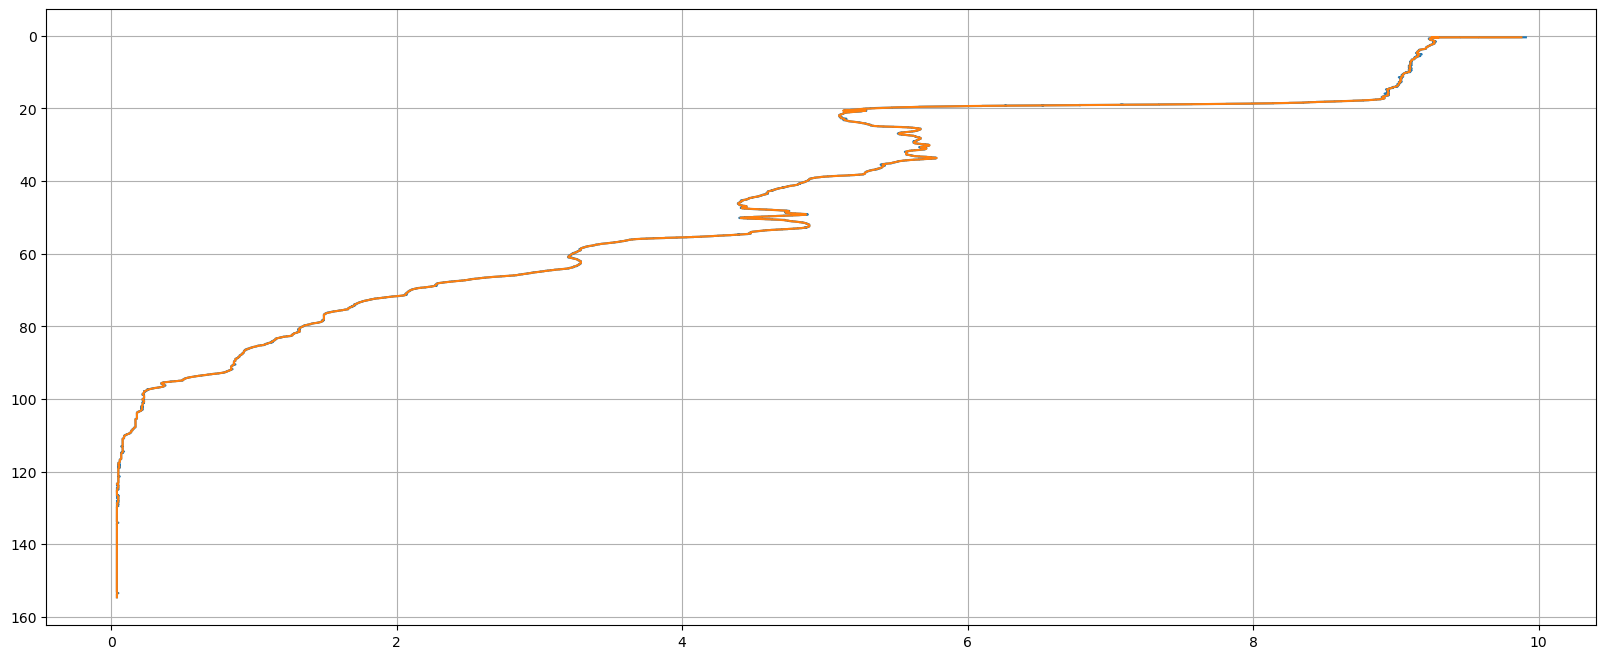

In [112]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(d_oxygen_conc, depth)
ax.plot(dox_savgol, depth)


ax.invert_yaxis()
ax.grid(True)